In [1]:
# ================================
# 0️⃣ IMPORTS
# ================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import Xception, EfficientNetV2M, ConvNeXtBase
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.xception import preprocess_input as xcep_preprocess
from tensorflow.keras.applications.convnext import preprocess_input as conv_preprocess

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


2026-02-01 04:00:08.838599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769918409.030730      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769918409.084057      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769918409.521451      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769918409.521489      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769918409.521492      24 computation_placer.cc:177] computation placer alr

,Class,Images
0,Fake,70001
1,Real,70001


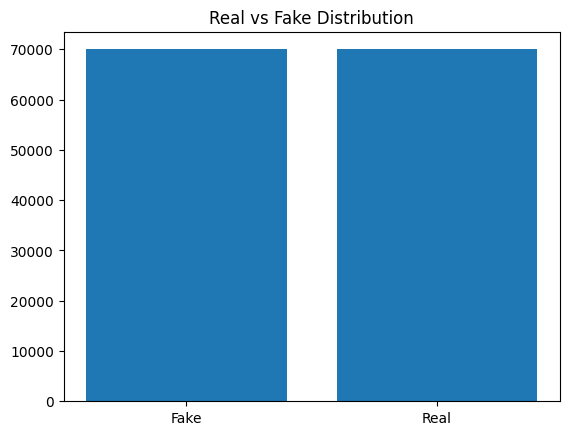

In [2]:
# 1️⃣ DATASET INFO
# ================================
BASE_DIR = '/kaggle/input/deepfake-and-real-images/Dataset/Train'

data = []
for cls in os.listdir(BASE_DIR):
    data.append([cls, len(os.listdir(os.path.join(BASE_DIR, cls)))])

df = pd.DataFrame(data, columns=["Class","Images"])
display(df)

plt.bar(df["Class"], df["Images"])
plt.title("Real vs Fake Distribution")
plt.show()

In [3]:
# 2️⃣ DATA GENERATORS
# ================================

datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.3,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 112002 images belonging to 2 classes.
Found 28000 images belonging to 2 classes.


In [4]:
def make_hybrid_dataset(gen):
    def _generator():
        for x, y in gen:
            x_xcep = xcep_preprocess(x.copy())
            x_conv = conv_preprocess(x.copy())
            yield (x_xcep, x_conv), y

    return tf.data.Dataset.from_generator(
        _generator,
        output_signature=(
            (
                tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            ),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )


In [5]:
# 3️⃣ EVALUATION FUNCTION
# ================================
def evaluate_model(model, name):
    val_gen.reset()
    preds = model.predict(val_gen)
    preds = (preds > 0.5).astype(int)
    y_true = val_gen.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    print(f"\n{name}")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1 Score :", f1)

    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(name + " Confusion Matrix")
    plt.show()

    return acc, prec, rec, f1

In [6]:
# ================================
# 4️⃣ MODIFIED CUSTOM CNN MODEL
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

custom_cnn = Sequential([

    # 🔹 Block 1
    Conv2D(32, (3,3), padding='same', activation='relu',
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 🔹 Block 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 🔹 Block 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # 🔹 Block 4
    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    # 🔹 Feature aggregation (IMPORTANT)
    GlobalAveragePooling2D(),

    # 🔹 Classifier
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

custom_cnn.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

custom_cnn.summary()


history_custom = custom_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[
        EarlyStopping(monitor='val_loss',
                      patience=7,
                      restore_best_weights=True),
        ModelCheckpoint("best_custom_cnn.keras",
                        save_best_only=True)
    ]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1769918533.165336      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,409 (1.74 MB)

 Trainable params: 455,937 (1.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1769918539.381185      78 service.cc:152] XLA service 0x79d0f8005e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769918539.381223      78 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769918540.125377      78 cuda_dnn.cc:529] Loaded cuDNN version 91002


   1/3501 ━━━━━━━━━━━━━━━━━━━━ 11:10:13 11s/step - accuracy: 0.4375 - loss: 0.8335

I0000 00:00:1769918547.190518      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3501/3501 ━━━━━━━━━━━━━━━━━━━━ 2357s 670ms/step - accuracy: 0.6013 - loss: 0.7497 - val_accuracy: 0.8277 - val_loss: 0.4623
Epoch 2/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1537s 439ms/step - accuracy: 0.8388 - loss: 0.4473 - val_accuracy: 0.9059 - val_loss: 0.3611
Epoch 3/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1525s 436ms/step - accuracy: 0.8913 - loss: 0.3775 - val_accuracy: 0.8907 - val_loss: 0.3886
Epoch 4/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1546s 442ms/step - accuracy: 0.9094 - loss: 0.3517 - val_accuracy: 0.9087 - val_loss: 0.3512
Epoch 5/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1549s 442ms/step - accuracy: 0.9190 - loss: 0.3358 - val_accuracy: 0.9174 - val_loss: 0.3334
Epoch 6/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1617s 462ms/step - accuracy: 0.9249 - loss: 0.3263 - val_accuracy: 0.9279 - val_loss: 0.3250
Epoch 7/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1615s 461ms/step - accuracy: 0.9291 - loss: 0.3188 - val_accuracy: 0.9112 - val_loss: 0.3473
Epoch 8/25
3501/3501 ━━━━━━━━━━━━━━━━━━━━ 1617s 462ms/step - accur

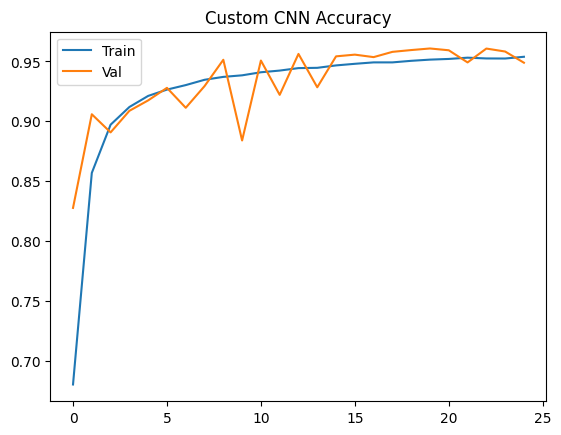

In [7]:
# 8️⃣ TRAINING CURVES
# ================================
def plot_history(history, name):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(name + " Accuracy")
    plt.legend()
    plt.show()

plot_history(history_custom, "Custom CNN")



875/875 ━━━━━━━━━━━━━━━━━━━━ 309s 353ms/step

Custom CNN
Accuracy : 0.9616428571428571
Precision: 0.9525276571908696
Recall   : 0.9717142857142858
F1 Score : 0.9620253164556962


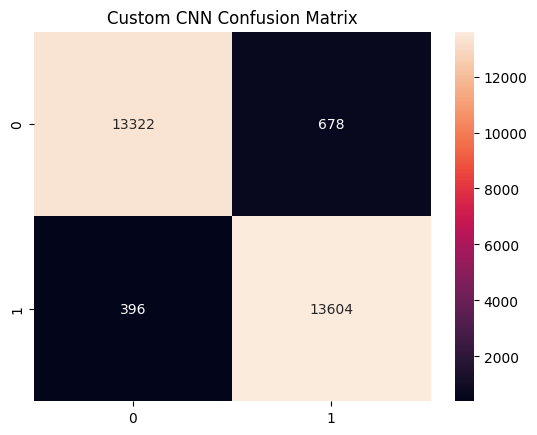

,Model,Accuracy,Precision,Recall,F1
0,Custom CNN,0.961643,0.952528,0.971714,0.962025


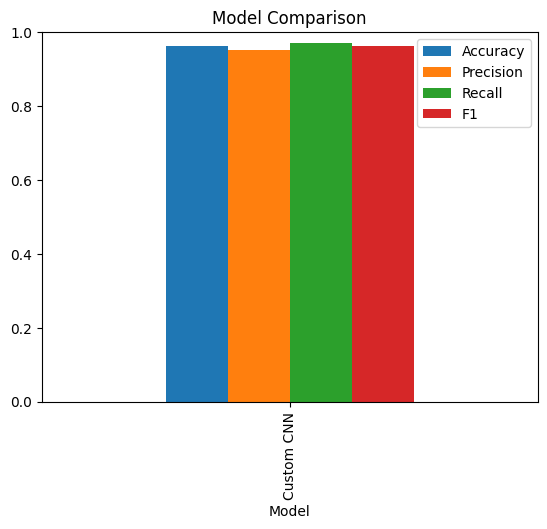

In [8]:
# 9️⃣ EVALUATION & COMPARISON
# ================================
results = []
results.append(["Custom CNN", *evaluate_model(custom_cnn, "Custom CNN")])


df_results = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
display(df_results)

df_results.set_index("Model").plot(kind="bar", ylim=(0,1), title="Model Comparison")
plt.show()

In [9]:
def plot_loss(history, name):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(name + " Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


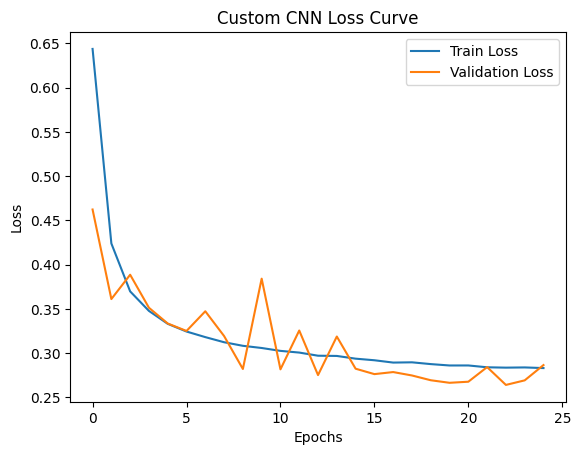

In [10]:
plot_loss(history_custom, "Custom CNN")




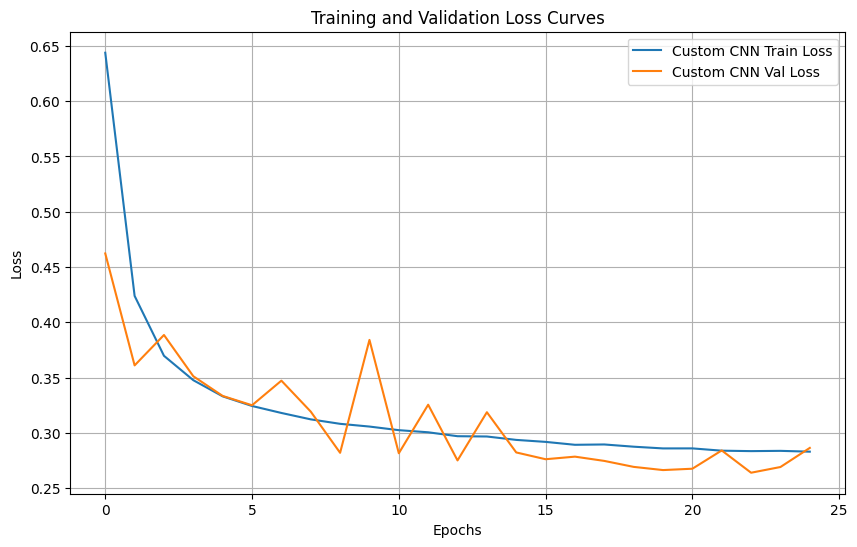

In [11]:
plt.figure(figsize=(10,6))

# Custom CNN
plt.plot(history_custom.history['loss'], label='Custom CNN Train Loss',  linestyle='-')
plt.plot(history_custom.history['val_loss'], label='Custom CNN Val Loss',  linestyle='-')

plt.title("Training and Validation Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


875/875 ━━━━━━━━━━━━━━━━━━━━ 307s 351ms/step

Custom CNN
Accuracy : 0.9607857142857142
Precision: 0.9513713965855024
Recall   : 0.9712142857142857
F1 Score : 0.9611904425279231


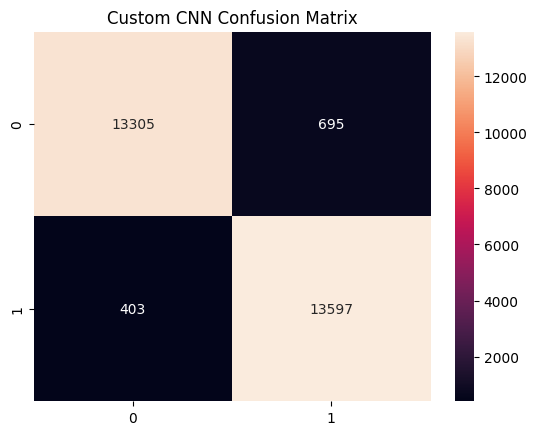

,Model,Accuracy,Precision,Recall,F1
0,Custom CNN,0.960786,0.951371,0.971214,0.96119


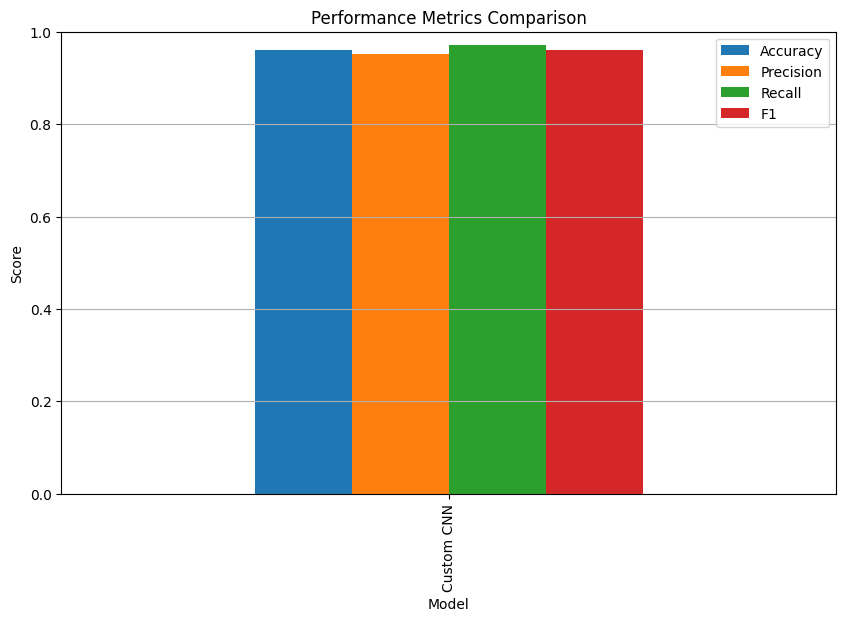

In [12]:
# Evaluate all models and store metrics
results = []

results.append(["Custom CNN", *evaluate_model(custom_cnn, "Custom CNN")])


# Convert to DataFrame
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1"]
)

# Show table
display(df_results)

# ==========================
# Bar chart comparison
# ==========================
df_results.set_index("Model").plot(kind="bar", figsize=(10,6))
plt.title("Performance Metrics Comparison")
plt.ylim(0,1)
plt.ylabel("Score")
plt.grid(axis='y')
plt.show()
